# Projeto Final - Aprendizado de Máquina
## Análise do Dataset SECOM

Este notebook implementa o pipeline solicitado no trabalho final da disciplina.

### Estrutura:
1. Carregamento e exploração dos dados (EDA)
2. Pré-processamento (imputação, escalonamento, remoção de colunas constantes)
3. Redução de dimensionalidade (PCA)
4. Modelagem com três classificadores (Logistic Regression, Random Forest, SVM)
5. Avaliação com 10-fold cross-validation e conjunto de teste
6. Métricas: Acurácia, F1-score, Balanced Accuracy, ROC-AUC
7. Conclusões


In [101]:
# Importação de bibliotecas principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from lightgbm import LGBMClassifier


## 1. Carregamento e Exploração dos Dados (EDA)
Carregaremos o dataset SECOM.
- Arquivo `secom.data` contém as features
- Arquivo `secom_labels.data` contém as labels (-1 = Pass, 1 = Fail)

Além disso, já e feito a divisão entre treino e teste para evitar data leakage.

In [92]:
# Ajuste os caminhos para os arquivos antes de executar
X = pd.read_csv('../data/raw/secom.data', sep=' ', header=None, na_values='NaN')
y = pd.read_csv('../data/raw/secom_labels.data', sep=' ', header=None, usecols=[0])
y = y[0]

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Classes:", y.value_counts())

X.head()

Shape X: (1567, 590)
Shape y: (1567,)
Classes: 0
-1    1463
 1     104
Name: count, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [93]:
# Explorando quantidade de NA's em cada coluna
X.isna().mean().sort_values(ascending=False).head(40)


157    0.911934
292    0.911934
293    0.911934
158    0.911934
492    0.855775
358    0.855775
220    0.855775
85     0.855775
517    0.649649
518    0.649649
383    0.649649
111    0.649649
109    0.649649
246    0.649649
382    0.649649
384    0.649649
245    0.649649
110    0.649649
244    0.649649
516    0.649649
580    0.605616
581    0.605616
579    0.605616
578    0.605616
72     0.506701
73     0.506701
346    0.506701
345    0.506701
112    0.456286
247    0.456286
385    0.456286
519    0.456286
566    0.174218
564    0.174218
567    0.174218
562    0.174218
563    0.174218
569    0.174218
568    0.174218
565    0.174218
dtype: float64

In [94]:
X.dtypes.describe()

count         590
unique          1
top       float64
freq          590
dtype: object

In [95]:
# O split é feito ANTES de qualquer processamento para simular dados "novos" no teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## 2. Pré-processamento
- Removendo variáveis com mais de 40% de valores faltantes
- Imputação de valores faltantes (média)
- Remoção de colunas constantes
- Padronização (z-score)


In [96]:
# Classe para remoção de colunas com 40 de NA

class ColumnDropperByNa(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.4):
        self.threshold = threshold
        self.columns_to_keep_ = []

    def fit(self, X, y=None):
        # Aprende quais colunas manter APENAS dos dados de treino (X)
        nan_frac = X.isna().mean()
        self.columns_to_keep_ = X.columns[nan_frac < self.threshold].tolist()
        return self

    def transform(self, X, y=None):
        # Aplica a transformação, mantendo apenas as colunas aprendidas
        return X[self.columns_to_keep_]

In [97]:
# Converta os nomes para string para evitar ambiguidades
X_train.columns = X_train.columns.astype(str)

# -----------------------
# Criar pipeline de pré processamento inical
# -----------------------

preprocessor_pipeline = Pipeline(steps=[
    ('remover_por_na', ColumnDropperByNa(threshold=0.4)),
    ('imputer', SimpleImputer(strategy="median")),
    ('remover_constantes', VarianceThreshold()),
    ('scaler', StandardScaler())
])

# -----------------------
# Aplicar transformação aos dados
# -----------------------
X_train_transformed = preprocessor_pipeline.fit_transform(X_train)

# Voltar para DataFrame
X_train_prepared = pd.DataFrame(X_train_transformed)

print("Shape antes:", X_train.shape)
print("Shape depois:", X_train_prepared.shape)
print(X_train_prepared.head())


Shape antes: (1253, 590)
Shape depois: (1253, 442)
        0         1         2         3         4         5         6    \
0  0.838989 -0.069524 -0.514321 -0.432298 -0.052392  0.744212 -0.148706   
1  0.787653 -0.089547  0.588034  0.090182 -0.030373  0.809944 -0.249296   
2  0.045762  0.343685  0.030977 -1.180420 -0.038124  0.857170 -0.110985   
3 -1.545221  0.911316  0.810785  0.837024 -0.024986 -0.725293  0.266225   
4 -0.433825 -0.372486 -2.819976 -1.148082 -0.037714  0.848539  0.417109   

        7         8         9    ...       432       433       434       435  \
0 -0.871008 -0.925512 -0.078733  ... -0.262093  0.031325 -0.753458 -0.139726   
1  0.850722  0.509065 -1.348471  ... -0.247292 -0.433732  0.117012  0.848277   
2 -1.253916  0.039687  0.545376  ... -0.240885  0.061823 -0.057082 -0.302641   
3  1.774046 -1.004844  0.642220  ... -0.229964 -0.269297  0.117012  0.102020   
4 -0.306150 -0.561910  0.050393  ... -0.254297 -0.177479 -0.405270  0.091509   

        436      

## 3. Redução de Dimensionalidade (PCA/LDA)
Aplicaremos PCA para reduzir a dimensionalidade e visualizar os dados.


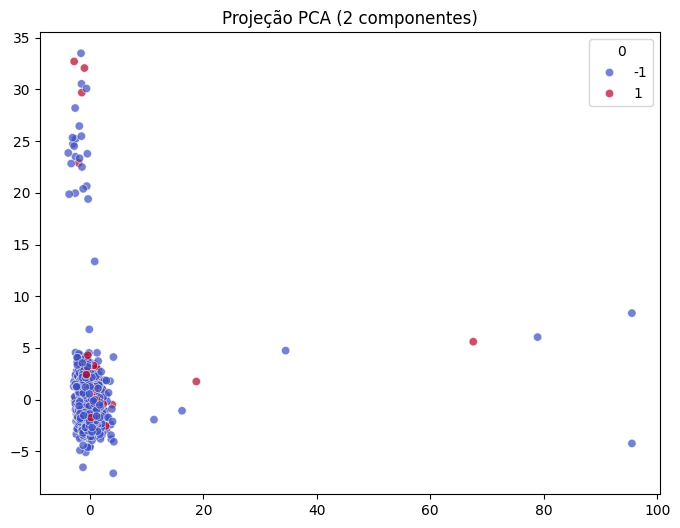

In [98]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_prepared)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_train, palette='coolwarm', alpha=0.7)
plt.title('Projeção PCA (2 componentes)')
plt.show()


A análise via PCA demonstrou que as direções de maior variância nos dados não são as mesmas que separam eficientemente as classes de operação normal das falhas, resultando em uma sobreposição visual significativa. Isso ocorre porque o PCA é uma técnica não supervisionada, que ignora os rótulos ao projetar os dados. Diante disso, a utilização da Análise de Discriminante Linear (LDA) é a próxima etapa lógica. Diferentemente do PCA, o LDA é um método supervisionado cujo objetivo é encontrar a projeção dos dados que maximiza a separação entre as classes. Portanto, ao invés de buscar a variância, o LDA buscará o eixo que melhor distingue os grupos, o que pode revelar uma estrutura de separação que não era visível com o PCA.

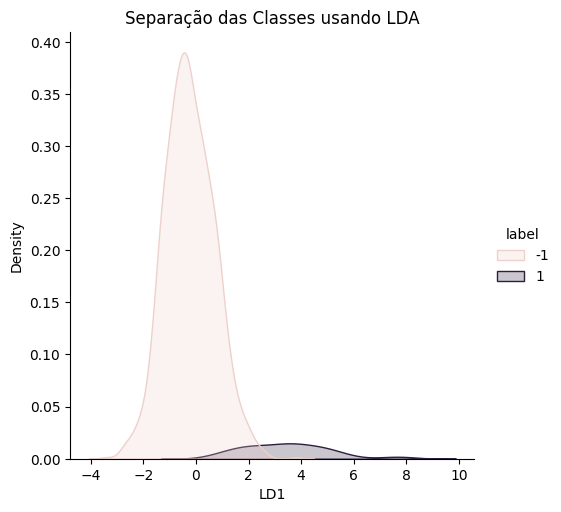

In [100]:
# Como há 2 classes, usamos n_components=1
lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X_train_prepared, y_train) # Note que 'y' é passado aqui!

# Para visualizar, podemos plotar a densidade de cada classe
df_lda = pd.DataFrame({'LD1': X_lda.flatten(), 'label': y_train})
sns.displot(df_lda, x='LD1', hue='label', kind='kde', fill=True)
plt.title('Separação das Classes usando LDA')
plt.show()

A análise com LDA (Análise de Discriminante Linear) foi bem-sucedida, demonstrando, ao contrário do PCA, que o problema é amplamente separável. A técnica projetou os dados de alta dimensão em um único eixo (LD1) no qual as duas classes apresentam distribuições claramente distintas: a classe normal (-1) forma um grupo denso e consistente, enquanto a classe de falha (1) se concentra em uma região separada, embora com maior variabilidade. Este resultado é extremamente promissor, pois confirma que um modelo de classificação pode aprender uma fronteira linear para distinguir os casos com alta eficácia, transformando um problema complexo em um que é visivelmente mais simples de resolver.

## 4. Modelagem
Usaremos Logistic Regression, Random Forest e SVM.
- Cada um com pelo menos 2 variações de hiperparâmetros via GridSearch.
- Validação com Stratified 10-Fold Cross Validation.


In [ ]:
#Definição da Validação Cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

models_and_params = {
    'LogisticRegression': {
        'pipeline': Pipeline([('preprocessor', preprocessor_pipeline), ('model', LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced'))]),
        'params': {
            'model__C': [0.01, 0.1, 1, 10],
            'model__penalty': ['l2']
        }
    },
    'RandomForest': {
        'pipeline': Pipeline([('preprocessor', preprocessor_pipeline), ('model', RandomForestClassifier(random_state=42, class_weight='balanced'))]),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [10, 20],
            'model__min_samples_leaf': [1, 5]
        }
    },
    'SVM': {
        'pipeline': Pipeline([('preprocessor', preprocessor_pipeline), ('model', SVC(probability=True, random_state=42, class_weight='balanced'))]),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf'],
            'model__gamma': ['scale', 'auto']
        }
    },
    'LightGBM': {
        'pipeline': Pipeline([('preprocessor', preprocessor_pipeline), ('model', LGBMClassifier(random_state=42))]),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__scale_pos_weight': [10, 20, 30] # Ajustado para testar mais pesos
        }
    }
}

# Loop de Treinamento e Avaliação (Nenhuma mudança aqui)
results = {}
for name, config in models_and_params.items():
    print(f"\nTreinando {name}...")
    grid = GridSearchCV(config['pipeline'], config['params'], cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
    
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    results[name] = {
        'best_score_cv': grid.best_score_,
        'best_params': grid.best_params_,
        'f1_test': f1_score(y_test, y_pred, pos_label=1),
        'roc_auc_test': roc_auc_score(y_test, y_prob),
        'balanced_accuracy_test': balanced_accuracy_score(y_test, y_pred),
        'confusion_matrix_test': confusion_matrix(y_test, y_pred)
    }
    print(f"Resultados para {name}:")
    print(results[name])


## 5. Resultados e Comparação
Aqui apresentamos os resultados de cada classificador no conjunto de teste.


In [ ]:
for model, res in results.items():
    print(f"\nModelo: {model}")
    print("Melhores parâmetros:", res['best_params'])
    print("Acurácia:", res['accuracy'])
    print("F1:", res['f1'])
    print("ROC-AUC:", res['roc_auc'])
    print("Balanced Accuracy:", res['balanced_accuracy'])
    print("Matriz de confusão:\n", res['confusion_matrix'])


## 6. Conclusões
Nesta seção você deverá comentar:
- Qual modelo apresentou melhor desempenho.
- Impacto da redução de dimensionalidade.
- Qual métrica é mais relevante para o problema (considerando desbalanceamento).
